# 학습 방법 - Scene

3개의 Scene에 대해서 각각 따로 학습

user별로 학습을 하지 않는 이유는 상관관계로 보았을 때 user끼리는 달라도 scene별로는 유사점이 꽤 보였기 때문.

In [1]:
from multiprocessing import cpu_count
from pathlib import Path
from typing import List, Union, AnyStr
from math import pi
import pickle

import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn import model_selection
from tqdm import tqdm
import torch_optimizer
from torch.utils.data import Dataset
import pandas as pd
import random

import torch_burn as tb
import utils

In [2]:
EXPERIMENT_NAME = 'Scene2-LSTM[Window120]'
CHECKPOINT_DIR = Path('checkpoint', EXPERIMENT_NAME)
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)

DATA_DIR = Path('data/1116')
TRAIN_FILES = sorted(list(DATA_DIR.glob('*scene1_0.csv')))
TEST_FILES = sorted(list(DATA_DIR.glob('*scene1_1.csv')))

# 데이터셋 생성

scene1에 대해서 모든 user의 데이터를 하나로 합친다.

In [3]:
WINDOW_SIZE = 120

In [4]:
class CSVSequentialDataset(Dataset):
    def __init__(self, csvfile,
                 window_size=300, randomized_window_size=False,
                 stride=30, randomized_stride=False):
        super(CSVSequentialDataset, self).__init__()

        self.xcols = ['input_orientation_yaw', 'input_orientation_pitch', 'input_orientation_roll',
                      'acceleration_x', 'acceleration_y', 'acceleration_z']
        self.ycols = ['input_orientation_yaw', 'input_orientation_pitch', 'input_orientation_roll']

        self.csv = pd.read_csv(csvfile)
        self.window_size = window_size

        self.indexes = []
        i = 0
        while i <= len(self.csv) - window_size * 2:
            if randomized_window_size:
                self.indexes.append((i, i + random.randint(window_size // 2, window_size)))
            else:
                self.indexes.append((i, i + window_size))

            if randomized_stride:
                i += random.randint(1, stride)
            else:
                i += stride

    def __len__(self):
        return len(self.indexes)

    def __getitem__(self, idx):
        s, t = self.indexes[idx]
        x = self.csv.iloc[s:t][self.xcols].to_numpy()
        y = self.csv.iloc[t + 6][self.ycols].to_numpy()

        x = torch.tensor(x, dtype=torch.float32) # 300, 6
        y = torch.tensor(y, dtype=torch.float32) # 3
        
        #x[:, :3] *= pi / 180
        x[:, 3:] /= 10

        return x, y

In [5]:
ds_train = [CSVSequentialDataset(f,  
                                 window_size=WINDOW_SIZE, randomized_window_size=False,
                                 stride=5, randomized_stride=True) for f in TRAIN_FILES]
ds_train = tb.data.ChainDataset(*ds_train)
ds_test = [CSVSequentialDataset(f,  
                                window_size=WINDOW_SIZE, randomized_window_size=False,
                                stride=5, randomized_stride=True) for f in TEST_FILES]
ds_test = tb.data.ChainDataset(*ds_test)

In [6]:
len(ds_train), len(ds_test)

(18114, 18818)

In [7]:
ds_train[0][0].shape, ds_train[0][1].shape

(torch.Size([120, 6]), torch.Size([3]))

In [8]:
x, y = ds_train[0]

In [9]:
x.shape

torch.Size([120, 6])

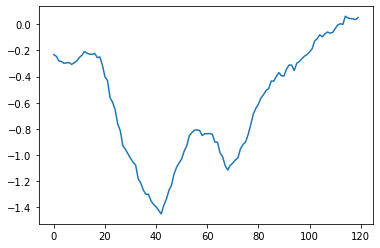

In [10]:
plt.plot(x[:, 2])

# 모델 생성

StackedLSTM Bidirectional

In [11]:
model = utils.BaselineLSTM(input_size=6,
                           hidden_size=64,
                           num_layers=8,
                           dropout=0.2,
                           bidirectional=True).cuda()

In [12]:
criterion = nn.MSELoss().cuda()
optimizer = torch_optimizer.RAdam(model.parameters())

In [13]:
metrics = [tb.metrics.ModuleMetric(criterion, 'loss'),
           utils.HPMetric('hp_metric'),
           utils.HPSignalHistory(CHECKPOINT_DIR / 'sample' / '{epoch:04d}.npy', 'hp_signal')]

In [14]:
callbacks = [tb.callbacks.EarlyStopping(metrics[0]),
             tb.callbacks.LRDecaying(optimizer, metrics[0])]

In [15]:
trainer = tb.Trainer(model, optimizer, metrics, callbacks, ncols=100)

In [16]:
trainer.fit(ds_train, ds_test, num_epochs=100, batch_size=256, shuffle=True, pin_memory=True)

[0002/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

                  validation
 - Yaw          :   9.707461
 - Pitch        :  12.123330
 - Roll         :   3.107818
 - RMS          :   9.144551
 - 99% Tile     :  43.898680
Save output signals into checkpoint/Scene2-LSTM[Window120]/sample/0001.npy


[0003/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

                  validation
 - Yaw          :   9.235278
 - Pitch        :   9.163331
 - Roll         :   3.080281
 - RMS          :   7.718919
 - 99% Tile     :  41.174661
Save output signals into checkpoint/Scene2-LSTM[Window120]/sample/0002.npy


[0004/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

                  validation
 - Yaw          :   9.113228
 - Pitch        :   8.118725
 - Roll         :   3.080488
 - RMS          :   7.267600
 - 99% Tile     :  38.927922
Save output signals into checkpoint/Scene2-LSTM[Window120]/sample/0003.npy


[0005/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

                  validation
 - Yaw          :   6.758407
 - Pitch        :   7.248407
 - Roll         :   2.977690
 - RMS          :   5.974449
 - 99% Tile     :  34.979325
Save output signals into checkpoint/Scene2-LSTM[Window120]/sample/0004.npy


[0006/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

                  validation
 - Yaw          :   5.022059
 - Pitch        :   5.647984
 - Roll         :   2.999225
 - RMS          :   4.694541
 - 99% Tile     :  31.755399
Save output signals into checkpoint/Scene2-LSTM[Window120]/sample/0005.npy


[0007/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

                  validation
 - Yaw          :   4.528611
 - Pitch        :   4.314840
 - Roll         :   2.920445
 - RMS          :   3.985606
 - 99% Tile     :  29.074381
Save output signals into checkpoint/Scene2-LSTM[Window120]/sample/0006.npy


[0008/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

                  validation
 - Yaw          :   3.515404
 - Pitch        :   3.528678
 - Roll         :   2.832698
 - RMS          :   3.308263
 - 99% Tile     :  26.560640
Save output signals into checkpoint/Scene2-LSTM[Window120]/sample/0007.npy


[0009/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

                  validation
 - Yaw          :   3.225881
 - Pitch        :   3.064713
 - Roll         :   2.735639
 - RMS          :   3.015653
 - 99% Tile     :  24.242294
Save output signals into checkpoint/Scene2-LSTM[Window120]/sample/0008.npy


[0010/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

                  validation
 - Yaw          :   2.615656
 - Pitch        :   2.620264
 - Roll         :   2.705732
 - RMS          :   2.647541
 - 99% Tile     :  22.122717
Save output signals into checkpoint/Scene2-LSTM[Window120]/sample/0009.npy


[0011/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

                  validation
 - Yaw          :   2.511599
 - Pitch        :   2.488844
 - Roll         :   2.419773
 - RMS          :   2.473714
 - 99% Tile     :  20.398889
Save output signals into checkpoint/Scene2-LSTM[Window120]/sample/0010.npy


[0012/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

                  validation
 - Yaw          :   2.270344
 - Pitch        :   2.352396
 - Roll         :   2.306004
 - RMS          :   2.309826
 - 99% Tile     :  18.882358
Save output signals into checkpoint/Scene2-LSTM[Window120]/sample/0011.npy


[0013/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

                  validation
 - Yaw          :   2.073145
 - Pitch        :   2.047176
 - Roll         :   2.161288
 - RMS          :   2.094439
 - 99% Tile     :  17.908372
Save output signals into checkpoint/Scene2-LSTM[Window120]/sample/0012.npy


[0014/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.948657
 - Pitch        :   1.853716
 - Roll         :   2.028297
 - RMS          :   1.944866
 - 99% Tile     :  16.848771
Save output signals into checkpoint/Scene2-LSTM[Window120]/sample/0013.npy


[0015/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.771009
 - Pitch        :   1.897350
 - Roll         :   1.789620
 - RMS          :   1.820179
 - 99% Tile     :  15.768530
Save output signals into checkpoint/Scene2-LSTM[Window120]/sample/0014.npy


[0016/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.773982
 - Pitch        :   1.710265
 - Roll         :   1.640865
 - RMS          :   1.709235
 - 99% Tile     :  14.578823
Save output signals into checkpoint/Scene2-LSTM[Window120]/sample/0015.npy


[0017/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.675241
 - Pitch        :   1.401283
 - Roll         :   1.490406
 - RMS          :   1.526580
 - 99% Tile     :  14.340537
Save output signals into checkpoint/Scene2-LSTM[Window120]/sample/0016.npy


[0018/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.509665
 - Pitch        :   1.774807
 - Roll         :   1.395761
 - RMS          :   1.568139
 - 99% Tile     :  13.583046
Save output signals into checkpoint/Scene2-LSTM[Window120]/sample/0017.npy


[0019/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.375708
 - Pitch        :   1.413584
 - Roll         :   1.480834
 - RMS          :   1.424039
 - 99% Tile     :  13.146063
Save output signals into checkpoint/Scene2-LSTM[Window120]/sample/0018.npy


[0020/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.531071
 - Pitch        :   1.366969
 - Roll         :   1.320068
 - RMS          :   1.408943
 - 99% Tile     :  12.572573
Save output signals into checkpoint/Scene2-LSTM[Window120]/sample/0019.npy


[0021/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.327775
 - Pitch        :   1.282356
 - Roll         :   1.186650
 - RMS          :   1.266960
 - 99% Tile     :  12.687341
Save output signals into checkpoint/Scene2-LSTM[Window120]/sample/0020.npy


[0022/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.583138
 - Pitch        :   1.260842
 - Roll         :   1.206848
 - RMS          :   1.360457
 - 99% Tile     :  12.733556
Save output signals into checkpoint/Scene2-LSTM[Window120]/sample/0021.npy


[0023/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.315504
 - Pitch        :   1.451154
 - Roll         :   1.222516
 - RMS          :   1.333035
 - 99% Tile     :  12.460433
Save output signals into checkpoint/Scene2-LSTM[Window120]/sample/0022.npy


[0024/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.344521
 - Pitch        :   1.189197
 - Roll         :   1.172334
 - RMS          :   1.237780
 - 99% Tile     :  12.184150
Save output signals into checkpoint/Scene2-LSTM[Window120]/sample/0023.npy


[0025/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.372781
 - Pitch        :   1.148725
 - Roll         :   1.233767
 - RMS          :   1.255160
 - 99% Tile     :  11.739769
Save output signals into checkpoint/Scene2-LSTM[Window120]/sample/0024.npy


[0026/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.266409
 - Pitch        :   1.212246
 - Roll         :   1.089330
 - RMS          :   1.191634
 - 99% Tile     :  11.293635
Save output signals into checkpoint/Scene2-LSTM[Window120]/sample/0025.npy


[0027/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.302589
 - Pitch        :   1.222422
 - Roll         :   1.160893
 - RMS          :   1.230004
 - 99% Tile     :  11.772026
Save output signals into checkpoint/Scene2-LSTM[Window120]/sample/0026.npy


[0028/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.290282
 - Pitch        :   1.227043
 - Roll         :   1.108373
 - RMS          :   1.210916
 - 99% Tile     :  11.760643
Save output signals into checkpoint/Scene2-LSTM[Window120]/sample/0027.npy


[0029/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.256942
 - Pitch        :   1.155274
 - Roll         :   1.066531
 - RMS          :   1.162189
 - 99% Tile     :  11.482077
Save output signals into checkpoint/Scene2-LSTM[Window120]/sample/0028.npy


[0030/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.154618
 - Pitch        :   1.168047
 - Roll         :   1.094183
 - RMS          :   1.139402
 - 99% Tile     :  11.458341
Save output signals into checkpoint/Scene2-LSTM[Window120]/sample/0029.npy


[0031/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.306825
 - Pitch        :   1.331021
 - Roll         :   1.070487
 - RMS          :   1.241686
 - 99% Tile     :  11.464887
Save output signals into checkpoint/Scene2-LSTM[Window120]/sample/0030.npy


[0032/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.335813
 - Pitch        :   1.176377
 - Roll         :   1.082791
 - RMS          :   1.202871
 - 99% Tile     :  10.542783
Save output signals into checkpoint/Scene2-LSTM[Window120]/sample/0031.npy


[0033/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.263908
 - Pitch        :   1.308517
 - Roll         :   1.061365
 - RMS          :   1.216028
 - 99% Tile     :  11.080589
Save output signals into checkpoint/Scene2-LSTM[Window120]/sample/0032.npy


[0034/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.258511
 - Pitch        :   1.139047
 - Roll         :   1.086612
 - RMS          :   1.163615
 - 99% Tile     :  11.127898
Save output signals into checkpoint/Scene2-LSTM[Window120]/sample/0033.npy


[0035/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   1.168742
 - Pitch        :   1.074096
 - Roll         :   1.042940
 - RMS          :   1.096565
 - 99% Tile     :  10.962510
Save output signals into checkpoint/Scene2-LSTM[Window120]/sample/0034.npy


[0036/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

val_loss is not improved for 4 epochs
                  validation
 - Yaw          :   1.191664
 - Pitch        :   1.253086
 - Roll         :   1.114405
 - RMS          :   1.187741
 - 99% Tile     :  11.076790
Save output signals into checkpoint/Scene2-LSTM[Window120]/sample/0035.npy


[0037/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.226251
 - Pitch        :   1.101193
 - Roll         :   1.127143
 - RMS          :   1.152789
 - 99% Tile     :  10.735691
Save output signals into checkpoint/Scene2-LSTM[Window120]/sample/0036.npy


[0038/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.160419
 - Pitch        :   1.204255
 - Roll         :   1.126312
 - RMS          :   1.164099
 - 99% Tile     :  11.416075
Save output signals into checkpoint/Scene2-LSTM[Window120]/sample/0037.npy


[0039/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.196421
 - Pitch        :   1.207799
 - Roll         :   1.007693
 - RMS          :   1.141000
 - 99% Tile     :  10.361503
Save output signals into checkpoint/Scene2-LSTM[Window120]/sample/0038.npy


[0040/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.283906
 - Pitch        :   1.107537
 - Roll         :   1.015996
 - RMS          :   1.141242
 - 99% Tile     :  11.196843
Save output signals into checkpoint/Scene2-LSTM[Window120]/sample/0039.npy


[0041/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.202281
 - Pitch        :   1.082060
 - Roll         :   1.007660
 - RMS          :   1.100259
 - 99% Tile     :  10.576563
Save output signals into checkpoint/Scene2-LSTM[Window120]/sample/0040.npy


[0042/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   1.198564
 - Pitch        :   1.209386
 - Roll         :   0.978226
 - RMS          :   1.133739
 - 99% Tile     :  10.315745
Save output signals into checkpoint/Scene2-LSTM[Window120]/sample/0041.npy


[0043/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.190243
 - Pitch        :   1.103431
 - Roll         :   0.973675
 - RMS          :   1.092746
 - 99% Tile     :   9.822811
Save output signals into checkpoint/Scene2-LSTM[Window120]/sample/0042.npy


[0044/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.141610
 - Pitch        :   1.081653
 - Roll         :   1.089195
 - RMS          :   1.104475
 - 99% Tile     :  10.409101
Save output signals into checkpoint/Scene2-LSTM[Window120]/sample/0043.npy


[0045/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.295157
 - Pitch        :   1.179773
 - Roll         :   1.028551
 - RMS          :   1.172918
 - 99% Tile     :  10.590352
Save output signals into checkpoint/Scene2-LSTM[Window120]/sample/0044.npy


[0046/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.341432
 - Pitch        :   1.170309
 - Roll         :   1.187745
 - RMS          :   1.235557
 - 99% Tile     :  10.077636
Save output signals into checkpoint/Scene2-LSTM[Window120]/sample/0045.npy


[0047/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.304710
 - Pitch        :   1.031538
 - Roll         :   1.038034
 - RMS          :   1.131938
 - 99% Tile     :   9.696716
Save output signals into checkpoint/Scene2-LSTM[Window120]/sample/0046.npy


[0048/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.303212
 - Pitch        :   1.194103
 - Roll         :   0.931342
 - RMS          :   1.153493
 - 99% Tile     :  10.101035
Save output signals into checkpoint/Scene2-LSTM[Window120]/sample/0047.npy


[0049/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.235205
 - Pitch        :   1.048653
 - Roll         :   0.978420
 - RMS          :   1.092811
 - 99% Tile     :  10.892037
Save output signals into checkpoint/Scene2-LSTM[Window120]/sample/0048.npy


[0050/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   1.285383
 - Pitch        :   1.067235
 - Roll         :   0.976951
 - RMS          :   1.117383
 - 99% Tile     :  10.065989
Save output signals into checkpoint/Scene2-LSTM[Window120]/sample/0049.npy


[0051/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

val_loss is not improved for 4 epochs
                  validation
 - Yaw          :   1.163228
 - Pitch        :   1.208998
 - Roll         :   0.954381
 - RMS          :   1.114394
 - 99% Tile     :   9.814122
Save output signals into checkpoint/Scene2-LSTM[Window120]/sample/0050.npy


[0052/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

Decaying lr from 0.001 to 0.0005 because val_loss did not improved for 5 epochs
val_loss is not improved for 5 epochs
                  validation
 - Yaw          :   1.379792
 - Pitch        :   1.071575
 - Roll         :   0.998614
 - RMS          :   1.161799
 - 99% Tile     :   9.939194
Save output signals into checkpoint/Scene2-LSTM[Window120]/sample/0051.npy


[0053/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.031098
 - Pitch        :   0.995078
 - Roll         :   0.947456
 - RMS          :   0.991802
 - 99% Tile     :   9.797074
Save output signals into checkpoint/Scene2-LSTM[Window120]/sample/0052.npy


[0054/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.144432
 - Pitch        :   1.016700
 - Roll         :   0.919848
 - RMS          :   1.031104
 - 99% Tile     :   9.728898
Save output signals into checkpoint/Scene2-LSTM[Window120]/sample/0053.npy


[0055/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.125574
 - Pitch        :   1.008070
 - Roll         :   0.905883
 - RMS          :   1.017144
 - 99% Tile     :   9.443980
Save output signals into checkpoint/Scene2-LSTM[Window120]/sample/0054.npy


[0056/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.103192
 - Pitch        :   0.990355
 - Roll         :   0.933049
 - RMS          :   1.011338
 - 99% Tile     :   9.580862
Save output signals into checkpoint/Scene2-LSTM[Window120]/sample/0055.npy


[0057/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

                  validation
 - Yaw          :   1.092809
 - Pitch        :   0.969724
 - Roll         :   0.927065
 - RMS          :   0.999007
 - 99% Tile     :   9.454491
Save output signals into checkpoint/Scene2-LSTM[Window120]/sample/0056.npy


[0058/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

val_loss is not improved for 1 epochs
                  validation
 - Yaw          :   1.096311
 - Pitch        :   1.033230
 - Roll         :   0.932183
 - RMS          :   1.022811
 - 99% Tile     :   9.377785
Save output signals into checkpoint/Scene2-LSTM[Window120]/sample/0057.npy


[0059/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

val_loss is not improved for 2 epochs
                  validation
 - Yaw          :   1.189045
 - Pitch        :   1.025005
 - Roll         :   0.921432
 - RMS          :   1.050952
 - 99% Tile     :   9.545939
Save output signals into checkpoint/Scene2-LSTM[Window120]/sample/0058.npy


[0060/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

val_loss is not improved for 3 epochs
                  validation
 - Yaw          :   1.297649
 - Pitch        :   1.016920
 - Roll         :   0.892955
 - RMS          :   1.082495
 - 99% Tile     :   9.456421
Save output signals into checkpoint/Scene2-LSTM[Window120]/sample/0059.npy


[0061/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

val_loss is not improved for 4 epochs
                  validation
 - Yaw          :   1.132789
 - Pitch        :   0.983540
 - Roll         :   0.899846
 - RMS          :   1.009997
 - 99% Tile     :   9.565598
Save output signals into checkpoint/Scene2-LSTM[Window120]/sample/0060.npy


[0062/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

Decaying lr from 0.0005 to 0.00025 because val_loss did not improved for 5 epochs
val_loss is not improved for 5 epochs
                  validation
 - Yaw          :   1.276813
 - Pitch        :   1.005582
 - Roll         :   0.940727
 - RMS          :   1.084192
 - 99% Tile     :   9.708995
Save output signals into checkpoint/Scene2-LSTM[Window120]/sample/0061.npy


[0063/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

val_loss is not improved for 6 epochs
                  validation
 - Yaw          :   1.157969
 - Pitch        :   0.977720
 - Roll         :   0.894923
 - RMS          :   1.016155
 - 99% Tile     :   9.536924
Save output signals into checkpoint/Scene2-LSTM[Window120]/sample/0062.npy


[0064/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

val_loss is not improved for 7 epochs
                  validation
 - Yaw          :   1.152069
 - Pitch        :   1.012070
 - Roll         :   0.919307
 - RMS          :   1.032259
 - 99% Tile     :   9.590390
Save output signals into checkpoint/Scene2-LSTM[Window120]/sample/0063.npy


[0065/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

val_loss is not improved for 8 epochs
                  validation
 - Yaw          :   1.188780
 - Pitch        :   0.961589
 - Roll         :   0.913415
 - RMS          :   1.028296
 - 99% Tile     :   9.779841
Save output signals into checkpoint/Scene2-LSTM[Window120]/sample/0064.npy


[0066/0100] Train:   0%|                                                     | 0/71 [00:00<?, ?it/s]

val_loss is not improved for 9 epochs
                  validation
 - Yaw          :   1.216074
 - Pitch        :   0.985752
 - Roll         :   0.925328
 - RMS          :   1.049885
 - 99% Tile     :   9.669776
Save output signals into checkpoint/Scene2-LSTM[Window120]/sample/0065.npy


[0066/0100] Validation: 100%|██████████████████████| 74/74 [00:03<00:00, 19.62it/s, val_loss 5.6656]

Decaying lr from 0.00025 to 0.000125 because val_loss did not improved for 5 epochs
val_loss is not improved for 10 epochs
Stop training because val_loss did not improved for 10 epochs
                  validation
 - Yaw          :   1.120664
 - Pitch        :   1.005898
 - Roll         :   0.899305
 - RMS          :   1.012664
 - 99% Tile     :   9.593661
Save output signals into checkpoint/Scene2-LSTM[Window120]/sample/0066.npy
